# Crypto Market Data Wrangling

This notebook uses **CryptoDataPy** to collect, clean and wrangle market data used to analyze digital assets.

In [30]:
# pip install cryptodatapy

# Data Collection

We will use **CryptoDataPy**, a python library we have created to make the process of analyzing digital assets as easy as possible. It allows you to create high quality ready-for-analysis data sets from a variety of sources with only a few lines of code. For more information, see our docs: https://cryptodatapy.readthedocs.io/en/latest/#

<br>

Our market data will be collectecd from CCXT and CryptoCompare.

**Market data:**

- *Perpetual futures*: OHLCV prices for perpetual futures traded on Binance.
- *Funding rates:*: funding rates for perpetual futures traded on Binance.
- *Spot:* OHLCV spot prices traded on Binance and CryptoCompare's aggregated exchange (CCCAGG) for extended backhistory back to 2010.

## Market Data

In [1]:
import pandas as pd
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from cryptodatapy.util.datacatalog import DataCatalog 
from cryptodatapy.extract.datarequest import DataRequest
from cryptodatapy.extract.getdata import GetData
from cryptodatapy.transform.clean import CleanData

### Asset Universe

Since factor-based strategies are implemented with long/short positions, we restrict our asset universe to liquid assets trading on the Binance perpetual futures exchange which includes ~ 150 assets.

Our universe is filtered down futher to assets with spot prices that go further back to increase our sample size and the statistical/economic significance of our results.

To do this, we find the intersection of assets with perpetual futures and spot traded on Binance as well as CryptoCompare's aggregated exchange for extended backhistory.

In [3]:
# get all Binance perp futures tickers from CCXT
data_req = DataRequest(source='ccxt')
fut_tickers = GetData(data_req).get_meta(method='get_markets_info', exch='binanceusdm', as_list=True)

In [4]:
# get all Binance spot tickers from CCXT
data_req = DataRequest(source='ccxt')
spot_tickers = GetData(data_req).get_meta(method='get_markets_info', exch='binance', as_list=True)

In [5]:
# find tickers intersection
binance_tickers = [ticker for ticker in fut_tickers if ticker in spot_tickers]

In [6]:
# keep only USDT tickers from Binance
bin_tickers = []
for ticker in binance_tickers:
    if '/' in ticker and ticker.split('/')[1] == 'USDT':
        bin_tickers.append(ticker.split('/')[0])

In [7]:
# get spot tickers from cryptocompare 
data_req = DataRequest(source='cryptocompare')
cc_tickers = GetData(data_req).get_meta(method='get_assets_info', as_list=True)

In [8]:
# find intersecting tickers for Binance and CryptoCompare
tickers = [ticker for ticker in bin_tickers if ticker in cc_tickers]

In [9]:
# remove FTT and SRM
tickers = [ticker for ticker in tickers if ticker not in ['FTT', 'SRM']]

### Perpetual Futures and Funding Rates

- OHLCV perp futures prices and funding rates for tickers which are traded on Binance exchance, through CCXT.

In [10]:
# pull OHLC and funding rates for perp futures on Binance USDM exchange
bin_perp_req = DataRequest(source='ccxt',
                           tickers=tickers, 
                           fields=['open', 'high', 'low', 'close', 'volume', 'funding_rate'], 
                           mkt_type='perpetual_future', 
                           freq='d')

In [11]:
df1 = GetData(bin_perp_req).get_series()

### OHLCV Spot Prices 

- OHLCV prices for those same tickers from the Binance spot exchange.

In [12]:
# pull spot OHLCV prices from Binance
bin_spot_req = DataRequest(source='ccxt',
                           tickers=tickers, 
                           fields=['open', 'high', 'low', 'close', 'volume'], 
                           freq='d')

In [13]:
df2 = GetData(bin_spot_req).get_series()

### OHLCV Spot Aggregated Spot Prices (extended history)

- OHLCV prices aggregated from many exchanges from CryptoCompare in order to extend our backhistory and increase our sample size.

In [14]:
# pull spot OHLCV prices from CryptoCompare
cc_spot_req = DataRequest(source='cryptocompare',
                       tickers=tickers, 
                       fields=['open', 'high', 'low', 'close', 'volume'], 
                       freq='d')

In [15]:
df3 = GetData(cc_spot_req).get_series()

Lastly, we can stitch together all these prices to create our extended data set.

In [16]:
# stitch binance perp futures, spot and cryptocompare data
df2['funding_rate'] = np.nan
df3['funding_rate'] = np.nan
df = df1.unstack().combine_first(df2.unstack()).combine_first(df3.unstack()).stack()

In [17]:
df.tail()

close  funding_rate     high      low    open      volume
date       ticker                                                             
2022-12-30 YFI      5188.0     -0.000023   5195.0   5146.0  5164.0     108.707
           ZEC       38.08      0.000199    38.15    37.91   37.99   14570.075
           ZEN       8.896      0.000184    8.945    8.874   8.902     38730.1
           ZIL     0.01603       0.00004  0.01607  0.01594   0.016  29795057.0
           ZRX      0.1531     -0.000353   0.1537   0.1525  0.1533   2157720.5

# Data Cleaning

### Spot, Futures and Funding rates: 

It's not uncommon for cryptoasset prices to have bad data, outliers, etc.

Below, we plot our funding rate and close data for visual inspection.

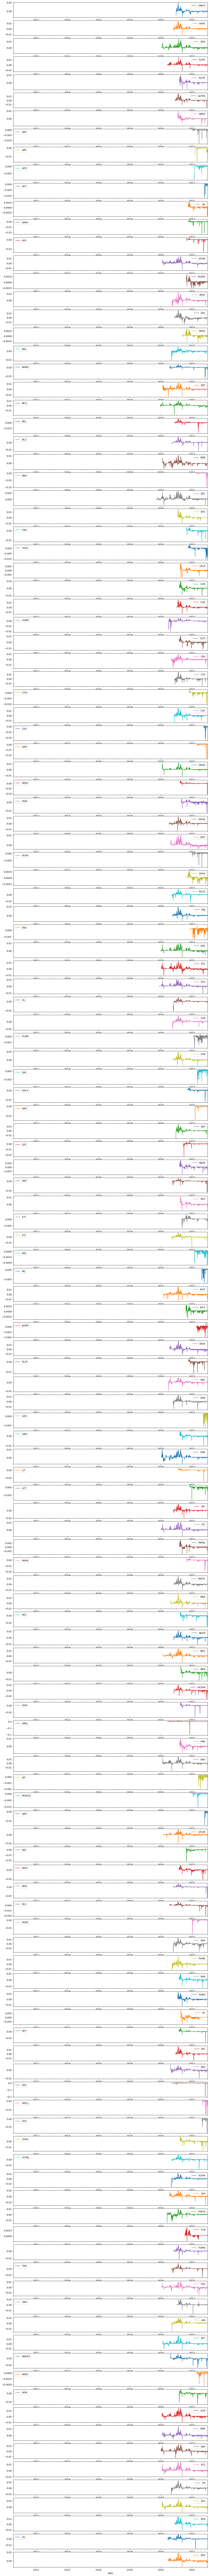

In [18]:
df.unstack().funding_rate.plot(subplots=True, sharex=False, figsize=(15,200));

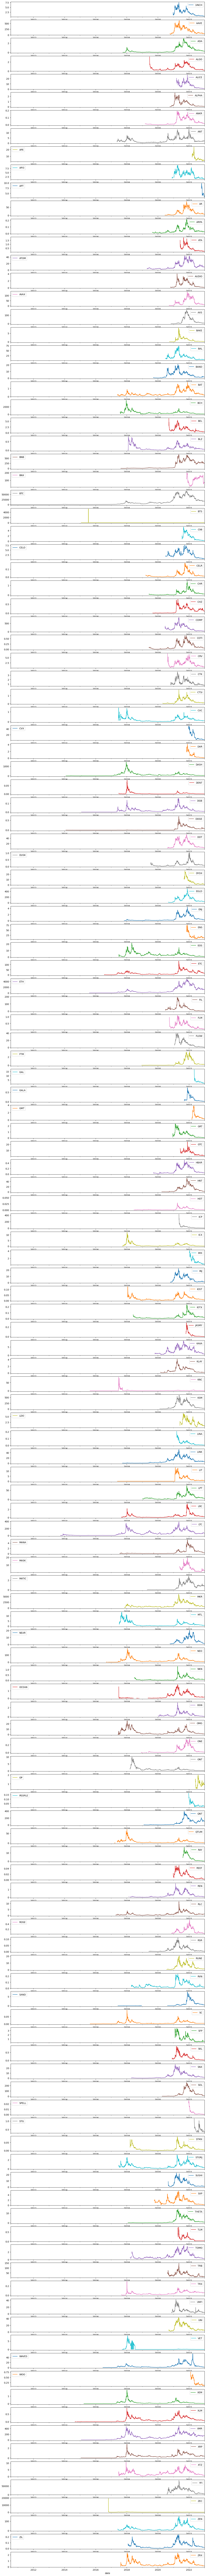

In [19]:
df.unstack().close.plot(subplots=True, sharex=False, figsize=(15,200));

Funding rate data seems to be has the potential for larger outliers which can reflect funding squeezes/deleveragings.

We can exclude funding rates before scrubbing our close data.

In addition, we will filter our assset universe for assets with a mininum of $5 mil average 30 day traded volume and remove all data before missing value gaps of 5 days or more.

In [20]:
# excl funding rates from cleaning
fund_df = df[['funding_rate']]

In [21]:
df = CleanData(df.drop(columns='funding_rate')).filter_outliers(od_method='iqr', thresh_val=10).\
                   repair_outliers(imp_method='fcst').get(attr='df')

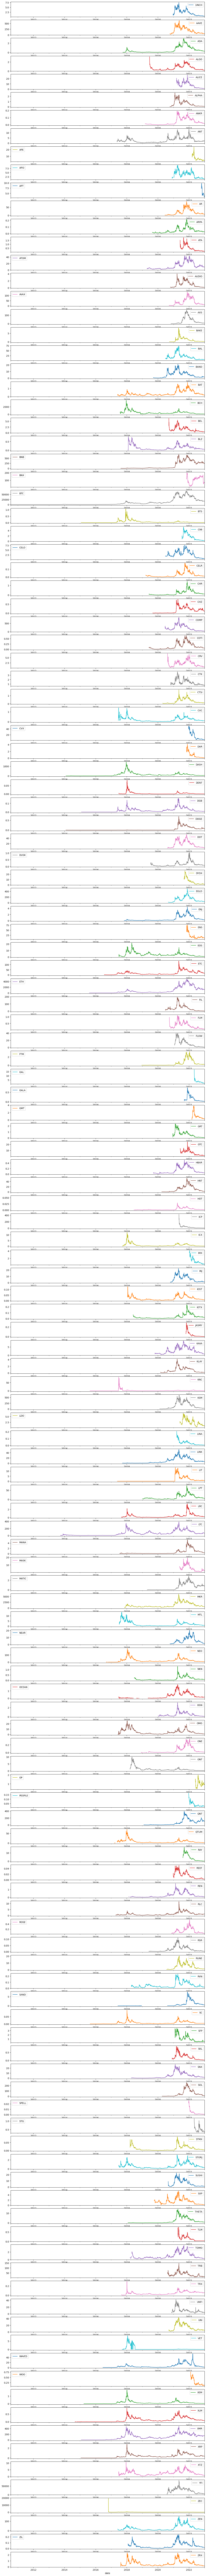

In [22]:
df.unstack().close.plot(subplots=True, sharex=False, figsize=(15,200));

In [23]:
# concat funding rates
df = pd.concat([df, fund_df], axis=1)

We will also restrict our asset price data to have a minimum of 30 observations and 3 assets in the cross section.

In [24]:
# drop tickers with nobs < ts_obs
obs = df.groupby(level=1).count().close
drop_tickers_list = obs[obs < 30].index.to_list()
df = df.drop(drop_tickers_list, level=1, axis=0)

# # drop tickers with nobs < cs_obs
obs = df.groupby(level=0).count().max(axis=1)
idx_start = obs[obs > 5].index[0]
df = df.unstack()[df.unstack().index > idx_start].stack()

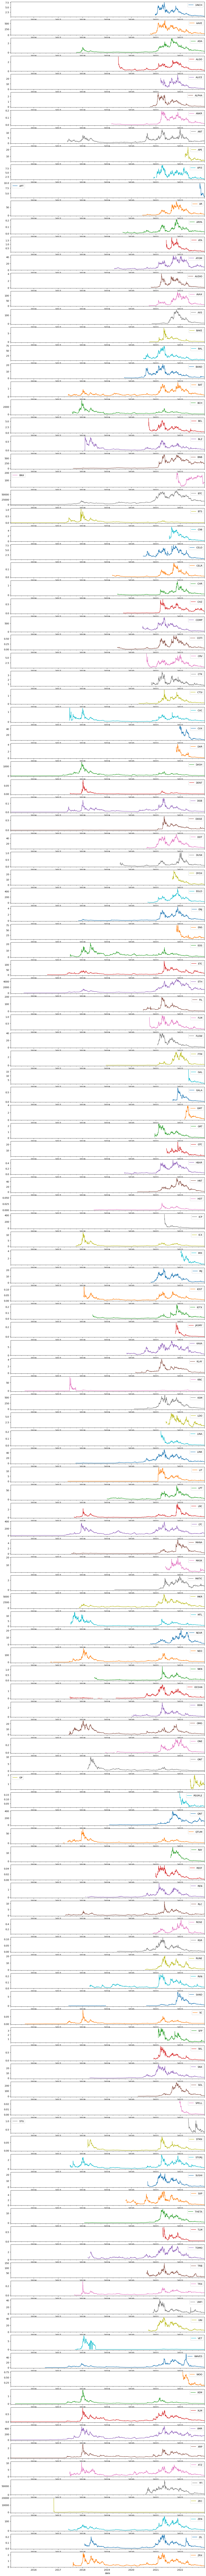

In [25]:
df.unstack().close.plot(subplots=True, sharex=False, figsize=(15,200));

In [26]:
len(df.unstack().close.columns)

142

In [28]:
df.head()

close      high       low      open     volume  \
date       ticker                                                      
2015-01-22 BTC        232.7    238.78    225.57    228.17   53706.05   
           DASH       1.484     1.627     1.484     1.595      1.358   
           DOGE    0.000154  0.000154  0.000147  0.000154   51131.94   
           LTC         1.41      1.45      1.36      1.36  689163.02   
           XLM      0.00532   0.00535  0.005196  0.005246   47681.66   

                   funding_rate  
date       ticker                
2015-01-22 BTC             <NA>  
           DASH            <NA>  
           DOGE            <NA>  
           LTC             <NA>  
           XLM             <NA>

In [29]:
# create csv
df.to_csv('../src/factorlab/datasets/data/crypto_market_data.csv')